<a href="https://colab.research.google.com/github/AyushSahu1306/Action-Sign-Detection/blob/main/Action_Sign_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Action Sign Detection with YOLOv10
 This project aims to detect and classify action signs using the YOLOv10 architecture. The dataset consists of various action signs, augmented to improve model robustness. The model is trained using the YOLOv10n architecture, leveraging data augmentation techniques for better generalization.


# Importing Necessary Libraries

In [ ]:
from google.colab import drive
import os
import shutil
import cv2
import numpy as np
import albumentations as A
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# Mounting drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Seprating images and labels

In [ ]:
# Paths
source_folder = '/content/drive/MyDrive/Action Sign Detection/sign-detection-val/obj_train_data/val'
images_folder = '/content/drive/MyDrive/Action Sign Detection/val/images'
labels_folder = '/content/drive/MyDrive/Action Sign Detection/val/labels'

In [ ]:
# Create directories for images and labels
os.makedirs(images_folder, exist_ok=True)
os.makedirs(labels_folder, exist_ok=True)

image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']

for filename in os.listdir(source_folder):

    file_extension = os.path.splitext(filename)[1].lower()

    # If it's an image, move it to the images folder
    if file_extension in image_extensions:
        shutil.move(os.path.join(source_folder, filename), os.path.join(images_folder, filename))

    elif file_extension == '.txt':
        shutil.move(os.path.join(source_folder, filename), os.path.join(labels_folder, filename))

print("Files have been successfully separated into images and labels.")


Files have been successfully separated into images and labels.


# Dataset




### Dataset Information
The dataset consists of action sign images annotated in the YOLO format. Each image corresponds to one of the following six classes:

- **Hello**
- **Yes**
- **No**
- **Thanks**
- **Please**
- **I love you**

To enhance the model's accuracy and generalization, the dataset has been augmented using various techniques, including:
- Horizontal and vertical flipping
- Random brightness and contrast adjustment
- Rotation and shift-scale-rotate transformations

These augmentations help the model perform better under different lighting, orientation, and positioning conditions, ensuring robust sign detection.

### Train data Sample

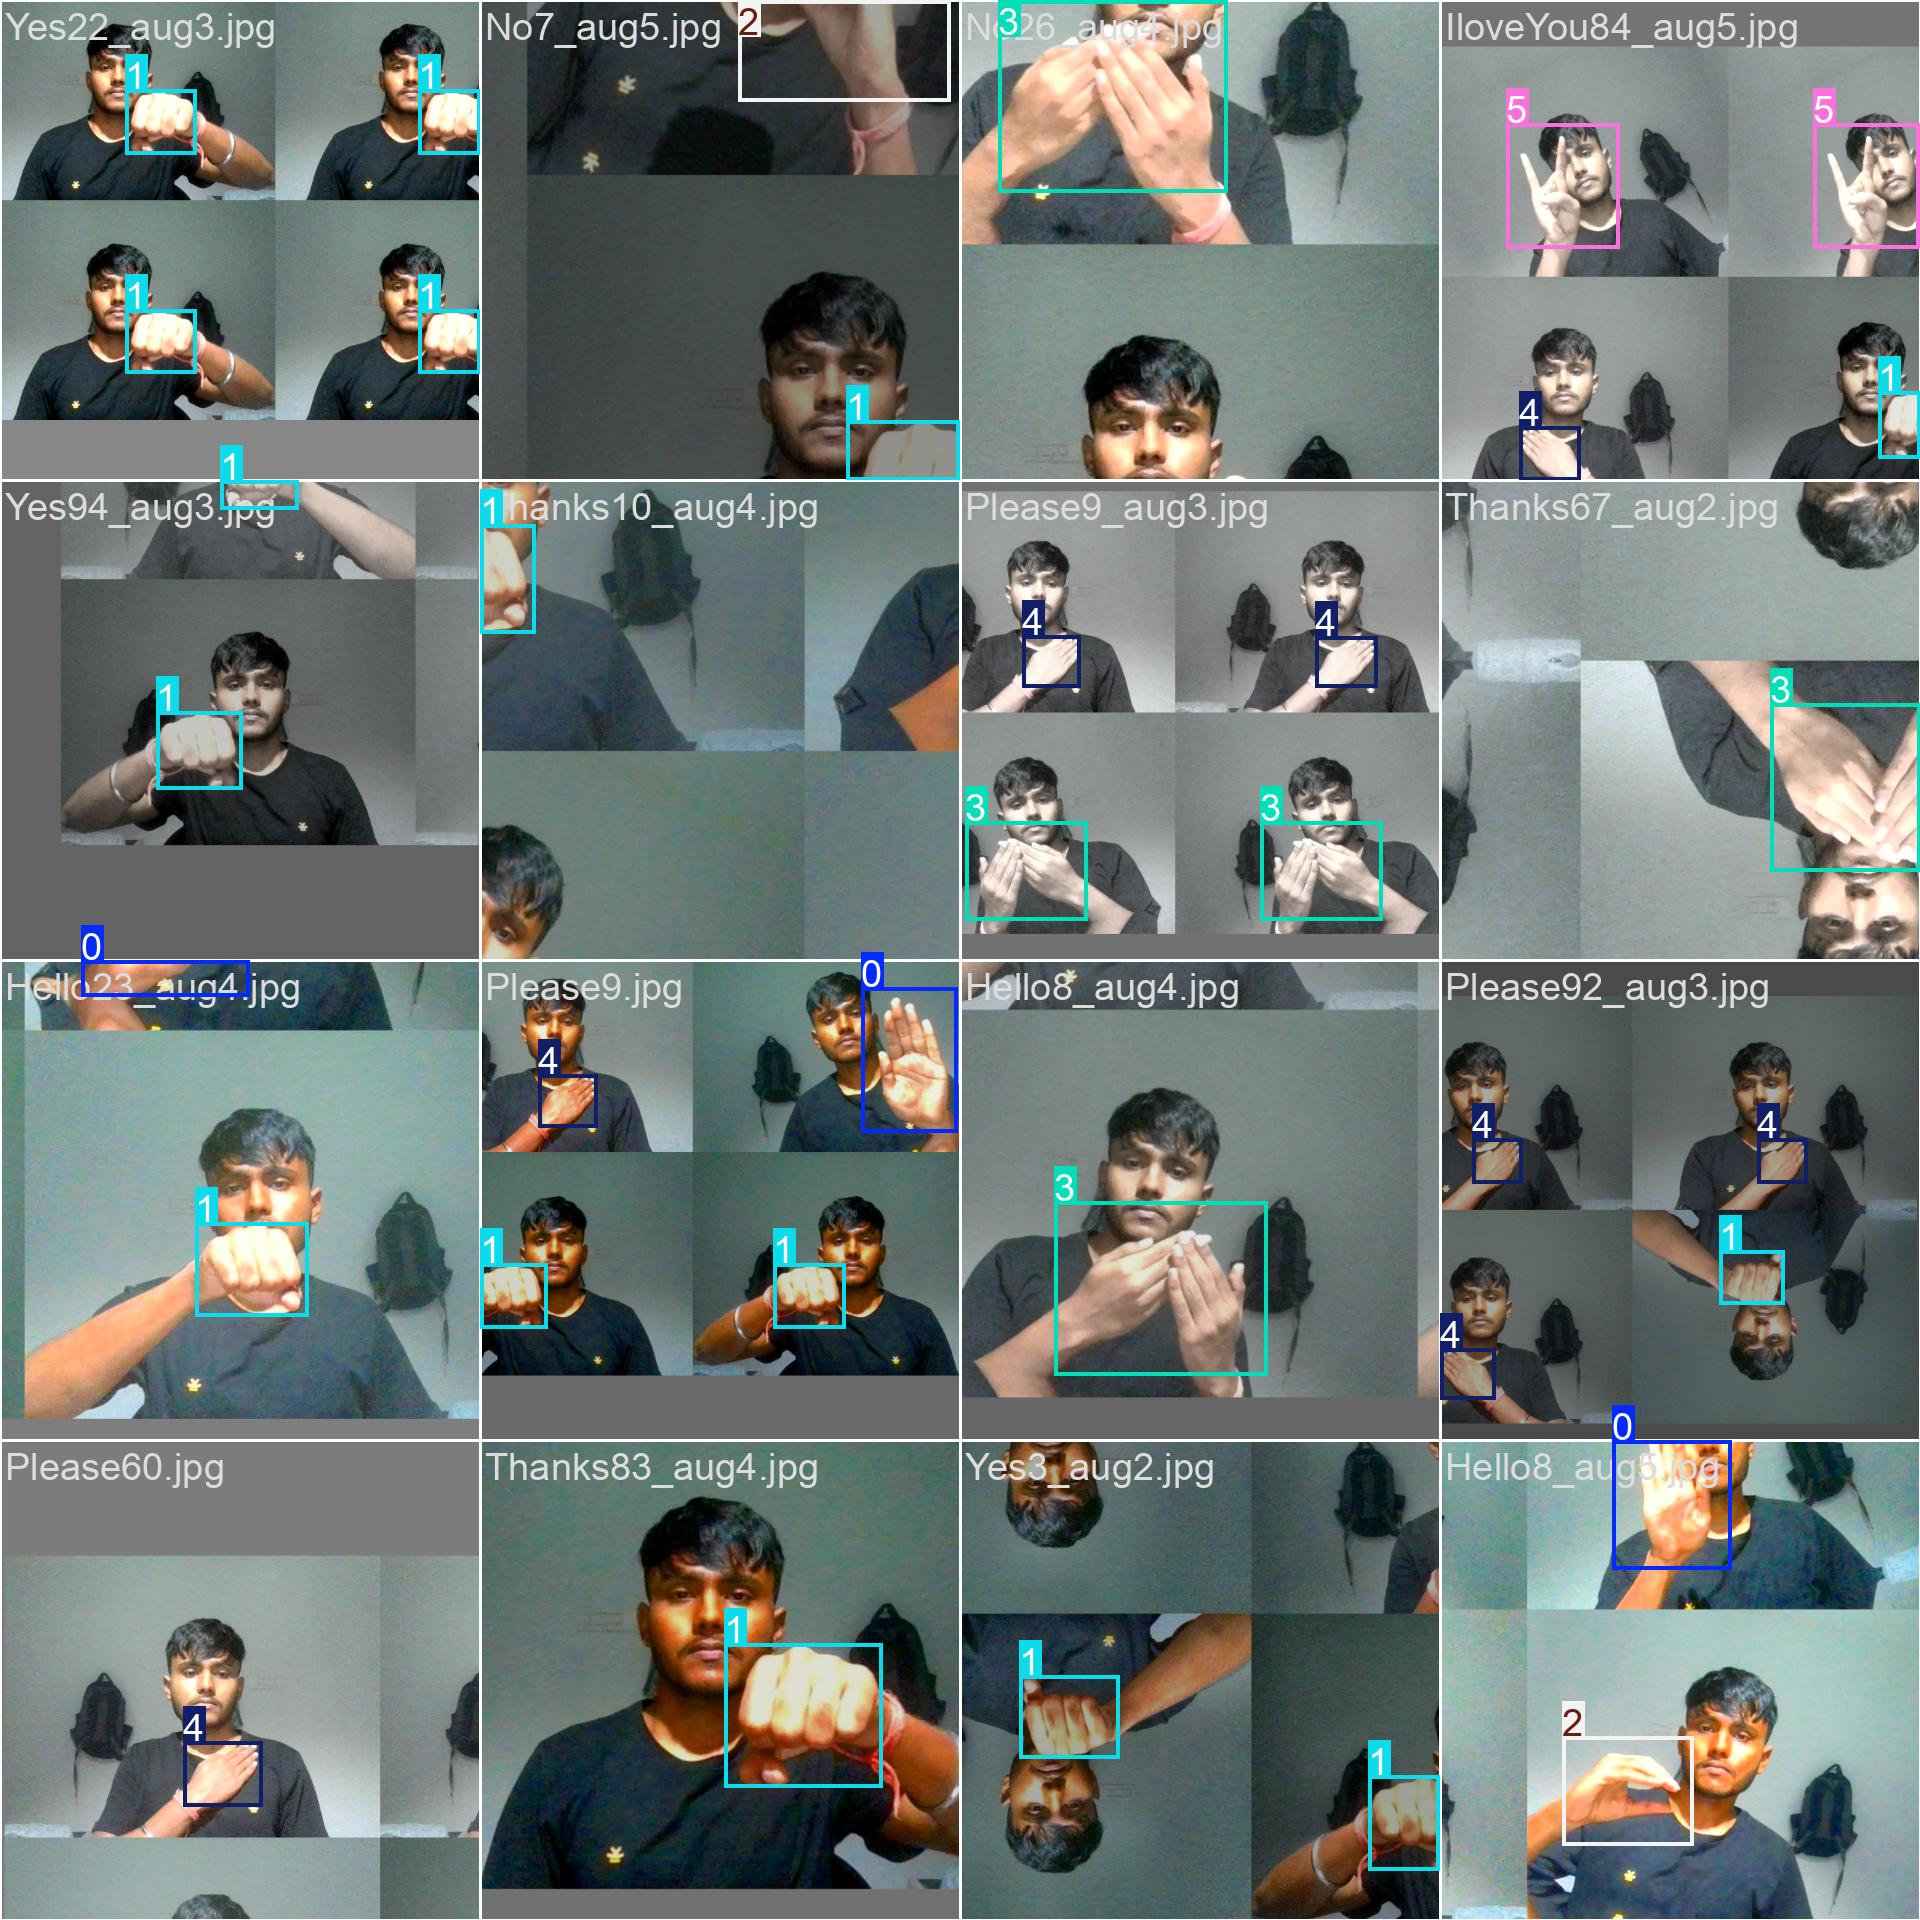

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
img=cv2.imread('/content/drive/MyDrive/Action Sign Detection/Results3/train/train_batch0.jpg')
cv2_imshow(img)

# Data Augmentation

In [ ]:
# Define augmentation pipeline with bbox_params
transformations = [
    A.Compose([
        A.HorizontalFlip(p=1.0),
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'])),

    A.Compose([
        A.VerticalFlip(p=1.0),
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'])),

    A.Compose([
        A.RandomBrightnessContrast(p=1.0),
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'])),

    A.Compose([
        A.Rotate(limit=20, p=1.0),
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'])),

    A.Compose([
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=1.0),
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'])),
]

In [ ]:
# Paths to images and labels folders
images_folder = '/content/drive/MyDrive/Action Sign Detection/train/images'
labels_folder = '/content/drive/MyDrive/Action Sign Detection/train/labels'
aug_images_folder = '/content/drive/MyDrive/Action Sign Detection/Dataset2/train/images'
aug_labels_folder = '/content/drive/MyDrive/Action Sign Detection/Dataset2/train/labels'

In [ ]:
# Create directories for augmented images and labels
os.makedirs(aug_images_folder, exist_ok=True)
os.makedirs(aug_labels_folder, exist_ok=True)

In [ ]:
# Function to read YOLO labels
def read_yolo_label(label_file):
    with open(label_file, 'r') as file:
        lines = file.readlines()
        boxes = []
        class_labels = []
        for line in lines:
            class_id, x, y, w, h = map(float, line.strip().split())
            boxes.append([x, y, w, h])
            class_labels.append(int(class_id))
        return boxes, class_labels

In [ ]:
# Function to save YOLO labels
def save_yolo_label(label_file, bboxes, class_labels):
    with open(label_file, 'w') as file:
        for bbox, class_id in zip(bboxes, class_labels):
            file.write(f"{class_id} {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}\n")


In [ ]:
# Counter to track the number of original and augmented images
counter = 1

for image_name in os.listdir(images_folder):

    base_name = image_name.split('.')[0]

    # Image path and corresponding label path
    image_path = os.path.join(images_folder, image_name)
    label_path = os.path.join(labels_folder, image_name.replace('.jpg', '.txt'))

    image = cv2.imread(image_path)
    height, width, _ = image.shape
    bboxes, class_labels = read_yolo_label(label_path)

    # Save the original image and labels with the base name + counter
    original_image_name = f"{base_name}{counter}.jpg"
    original_label_name = f"{base_name}{counter}.txt"
    cv2.imwrite(os.path.join(aug_images_folder, original_image_name), image)
    save_yolo_label(os.path.join(aug_labels_folder, original_label_name), bboxes, class_labels)

    print(f"Original image and labels saved: {original_image_name}")

    # Apply each augmentation from the list
    for i, transform in enumerate(transformations):
        augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
        augmented_image = augmented['image']
        augmented_bboxes = augmented['bboxes']
        augmented_class_labels = augmented['class_labels']

        new_image_name = f"{base_name}{counter}_aug{i+1}.jpg"
        new_label_name = f"{base_name}{counter}_aug{i+1}.txt"
        cv2.imwrite(os.path.join(aug_images_folder, new_image_name), augmented_image)
        save_yolo_label(os.path.join(aug_labels_folder, new_label_name), augmented_bboxes, augmented_class_labels)

        print(f"Augmented image and labels saved: {new_image_name}")

    counter += 1


# Size of Image

In [ ]:
image_path = '/content/drive/MyDrive/Action Sign Detection/Dataset2/val/images/No13_aug5.jpg'
image = cv2.imread(image_path)

height, width, channels = image.shape
print(f"Width: {width}, Height: {height}, Channels: {channels}")


Width: 640, Height: 480, Channels: 3


# Model Training


The YOLOv10 model is trained using the following parameters:
- Epochs: 50
- Image Size: 640x480

In [ ]:
!pip install ultralytics

In [ ]:
from ultralytics import YOLO

model = YOLO("yolov10n.pt")

100%|██████████| 5.59M/5.59M [00:00<00:00, 146MB/s]


In [ ]:
# Training the model

results = model.train(data="/content/drive/MyDrive/Action Sign Detection/data.yaml", epochs=50, imgsz=640,project="/content/drive/MyDrive/Action Sign Detection/Results3")

Ultralytics YOLOv8.2.89 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov10n.pt, data=/content/drive/MyDrive/Action Sign Detection/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/Action Sign Detection/Results3, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=Fa

100%|██████████| 755k/755k [00:00<00:00, 91.3MB/s]


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1      9856  ultralytics.nn.modules.block.SCDown          [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1     36096  ultralytics

100%|██████████| 6.25M/6.25M [00:00<00:00, 233MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/Action Sign Detection/Dataset2/train/labels.cache... 576 images, 6 backgrounds, 0 corrupt: 100%|██████████| 576/576 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/Action Sign Detection/Dataset2/val/labels.cache... 144 images, 0 backgrounds, 0 corrupt: 100%|██████████| 144/144 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/Action Sign Detection/Results3/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005), 107 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/Action Sign Detection/Results3/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.97G      3.008      11.55      3.364         34        640: 100%|██████████| 36/36 [03:23<00:00,  5.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]

                   all        144        144    0.00354      0.993      0.303      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.97G       2.58      8.581      2.813         39        640: 100%|██████████| 36/36 [00:14<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]

                   all        144        144    0.00459          1      0.621      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.97G      2.511      7.524      2.748         30        640: 100%|██████████| 36/36 [00:17<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


                   all        144        144      0.693      0.422      0.661      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.97G      2.533      6.799      2.776         37        640: 100%|██████████| 36/36 [00:18<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]


                   all        144        144      0.694      0.587      0.775      0.525

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.97G      2.452      6.203      2.679         37        640: 100%|██████████| 36/36 [00:16<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

                   all        144        144      0.629      0.665       0.77      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.97G      2.366      5.397      2.596         30        640: 100%|██████████| 36/36 [00:15<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.68it/s]

                   all        144        144      0.753      0.666      0.835      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.98G      2.289      4.893      2.532         33        640: 100%|██████████| 36/36 [00:15<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.75it/s]

                   all        144        144      0.663      0.743      0.835       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.97G      2.235      4.466      2.526         49        640: 100%|██████████| 36/36 [00:16<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.26it/s]

                   all        144        144       0.75      0.823      0.905      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.97G      2.189      3.898      2.462         25        640: 100%|██████████| 36/36 [00:15<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        144        144      0.846      0.721      0.848      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.97G      2.301      3.778      2.511         35        640: 100%|██████████| 36/36 [00:15<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.87it/s]


                   all        144        144      0.778      0.807      0.895      0.662

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.97G      2.078       3.32      2.421         31        640: 100%|██████████| 36/36 [00:16<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        144        144      0.813      0.875      0.922       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.97G      2.038      3.142      2.416         24        640: 100%|██████████| 36/36 [00:16<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.85it/s]

                   all        144        144       0.89      0.829      0.944      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.97G       1.97      2.822      2.364         29        640: 100%|██████████| 36/36 [00:16<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.56it/s]

                   all        144        144      0.842      0.807      0.908      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.97G      1.967      2.703      2.372         35        640: 100%|██████████| 36/36 [00:16<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.84it/s]

                   all        144        144      0.782      0.854      0.916      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.97G       1.89      2.539      2.293         29        640: 100%|██████████| 36/36 [00:15<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.91it/s]

                   all        144        144      0.806      0.882      0.943      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.97G      1.913      2.354      2.298         22        640: 100%|██████████| 36/36 [00:16<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]

                   all        144        144      0.865      0.917      0.961      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.97G      1.857       2.21      2.289         24        640: 100%|██████████| 36/36 [00:16<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.29it/s]


                   all        144        144      0.866      0.904      0.959      0.744

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.97G      1.787      2.021      2.236         31        640: 100%|██████████| 36/36 [00:15<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.74it/s]

                   all        144        144      0.842      0.917      0.973      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.97G      1.802      2.033      2.268         27        640: 100%|██████████| 36/36 [00:15<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.64it/s]

                   all        144        144      0.887      0.898      0.959      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.97G      1.787      2.003      2.255         25        640: 100%|██████████| 36/36 [00:15<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.73it/s]

                   all        144        144      0.877      0.916      0.978      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.97G      1.754      1.887      2.231         40        640: 100%|██████████| 36/36 [00:19<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.80it/s]

                   all        144        144      0.854      0.929      0.957      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.97G      1.693       1.79      2.206         40        640: 100%|██████████| 36/36 [00:16<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.89it/s]

                   all        144        144      0.875      0.902      0.962      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.97G      1.703      1.682      2.182         31        640: 100%|██████████| 36/36 [00:15<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.93it/s]


                   all        144        144      0.868      0.889      0.961      0.771

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.97G      1.711      1.689      2.198         33        640: 100%|██████████| 36/36 [00:16<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]

                   all        144        144      0.833      0.849      0.941      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.97G       1.71       1.67      2.216         33        640: 100%|██████████| 36/36 [00:15<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]

                   all        144        144      0.887      0.897      0.967      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.97G      1.631      1.596      2.164         29        640: 100%|██████████| 36/36 [00:16<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]

                   all        144        144      0.859      0.953      0.968      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.97G      1.596      1.517      2.135         39        640: 100%|██████████| 36/36 [00:16<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]


                   all        144        144      0.951      0.905      0.985      0.802

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.97G      1.612      1.543      2.133         32        640: 100%|██████████| 36/36 [00:15<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]

                   all        144        144      0.892       0.95      0.977      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.97G      1.554      1.441       2.12         37        640: 100%|██████████| 36/36 [00:15<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]

                   all        144        144      0.924      0.967      0.986      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.97G      1.551      1.385      2.107         42        640: 100%|██████████| 36/36 [00:16<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]

                   all        144        144      0.947      0.896       0.98      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.97G       1.57      1.403      2.133         27        640: 100%|██████████| 36/36 [00:17<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]


                   all        144        144      0.881       0.95      0.979      0.823

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.97G      1.539      1.345      2.106         27        640: 100%|██████████| 36/36 [00:16<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.84it/s]

                   all        144        144      0.924       0.96      0.985      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.97G      1.457      1.312      2.065         32        640: 100%|██████████| 36/36 [00:16<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

                   all        144        144      0.939      0.921      0.975      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.97G      1.451      1.265      2.069         33        640: 100%|██████████| 36/36 [00:16<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        144        144      0.874      0.971      0.983      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.97G      1.443      1.243      2.054         33        640: 100%|██████████| 36/36 [00:15<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

                   all        144        144      0.963      0.951      0.983      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.97G      1.387      1.202      2.014         39        640: 100%|██████████| 36/36 [00:15<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.26it/s]

                   all        144        144      0.944      0.939      0.974      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.97G      1.339       1.17      2.024         31        640: 100%|██████████| 36/36 [00:16<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.43it/s]

                   all        144        144      0.875      0.929      0.967      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.97G      1.362      1.174      2.018         35        640: 100%|██████████| 36/36 [00:15<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]

                   all        144        144       0.94      0.961      0.986      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.97G      1.385      1.135      2.027         30        640: 100%|██████████| 36/36 [00:16<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.30it/s]


                   all        144        144      0.881      0.943       0.97      0.824

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.97G      1.365      1.202      2.029         36        640: 100%|██████████| 36/36 [00:16<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]

                   all        144        144       0.93      0.925      0.976      0.834


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.01G       1.12      1.047       1.91         16        640: 100%|██████████| 36/36 [00:21<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        144        144      0.919      0.953      0.979      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.97G       1.08      1.008      1.875         16        640: 100%|██████████| 36/36 [00:15<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]

                   all        144        144      0.911      0.915       0.97       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.97G      1.052     0.9846      1.883         16        640: 100%|██████████| 36/36 [00:15<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.14it/s]


                   all        144        144      0.909      0.932      0.967      0.835

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.97G     0.9924      0.961       1.85         16        640: 100%|██████████| 36/36 [00:15<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.35it/s]


                   all        144        144      0.898      0.942      0.972      0.829

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.97G     0.9996     0.9351      1.839         16        640: 100%|██████████| 36/36 [00:18<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]


                   all        144        144      0.946      0.941      0.978      0.838

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.97G     0.9752     0.9154      1.811         16        640: 100%|██████████| 36/36 [00:15<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]

                   all        144        144      0.949      0.904      0.977      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.97G      0.944     0.8851      1.796         16        640: 100%|██████████| 36/36 [00:15<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]

                   all        144        144       0.95      0.931      0.981      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.97G     0.9535     0.8624      1.818         16        640: 100%|██████████| 36/36 [00:15<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        144        144      0.954      0.919      0.977      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.97G     0.9179     0.8641      1.791         16        640: 100%|██████████| 36/36 [00:15<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]


                   all        144        144      0.897      0.977      0.976      0.847

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.97G      0.883      0.866      1.795         16        640: 100%|██████████| 36/36 [00:15<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.83it/s]

                   all        144        144      0.877      0.965      0.973      0.846



50 epochs completed in 0.333 hours.
Optimizer stripped from /content/drive/MyDrive/Action Sign Detection/Results3/train/weights/last.pt, 5.7MB
Optimizer stripped from /content/drive/MyDrive/Action Sign Detection/Results3/train/weights/best.pt, 5.7MB

Validating /content/drive/MyDrive/Action Sign Detection/Results3/train/weights/best.pt...
Ultralytics YOLOv8.2.89 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv10n summary (fused): 285 layers, 2,696,756 parameters, 0 gradients, 8.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


                   all        144        144      0.897      0.978      0.975      0.845
                 Hello         24         24          1      0.995      0.995      0.919
                   Yes         24         24      0.977      0.958      0.989      0.821
                    No         24         24      0.785      0.914      0.925       0.77
                Thanks         24         24      0.979          1      0.995      0.865
                Please         24         24      0.793          1      0.982      0.854
            I Love You         24         24      0.846          1      0.966      0.843
Speed: 0.6ms preprocess, 4.6ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to /content/drive/MyDrive/Action Sign Detection/Results3/train


# Results

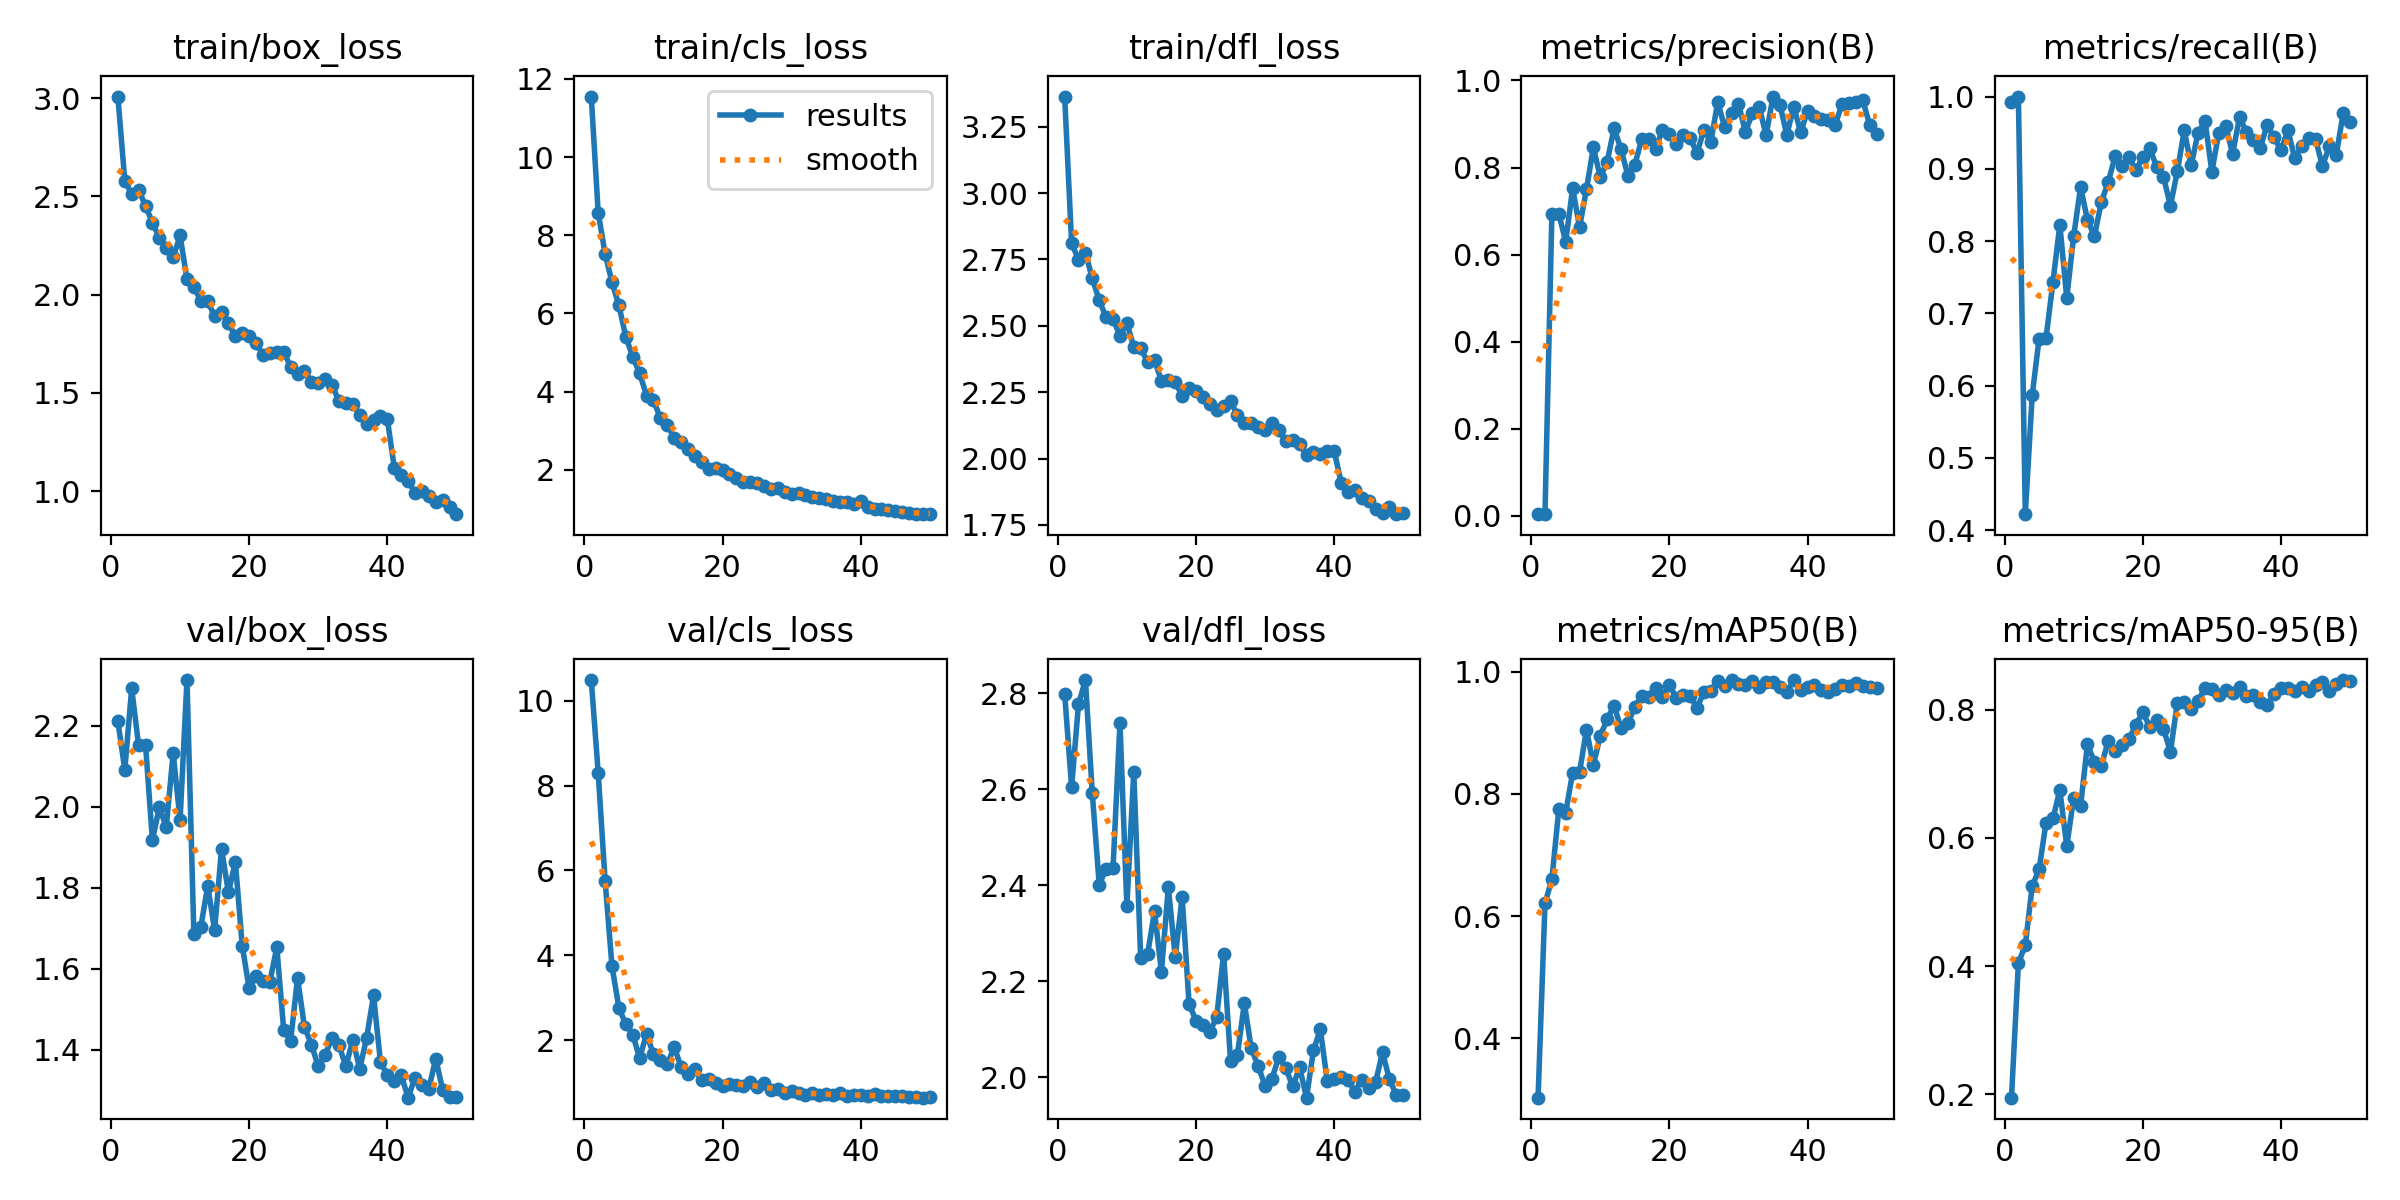

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Action Sign Detection/Results3/train/results.png')

cv2_imshow(img)


# Prediction on test data

In [ ]:
test_video = '/content/drive/MyDrive/Action Sign Detection/WIN_20240906_19_14_27_Pro.mp4'
output_folder = '/content/drive/MyDrive/Action Sign Detection'

os.makedirs(output_folder, exist_ok=True)
model = YOLO('/content/drive/MyDrive/Action Sign Detection/Results3/train/weights/best.pt')

results = model.predict(
    source=test_video,
    save=True,
    save_txt=True,
    project=output_folder,
    name='Test_results3',
    show=True
)

print(results)


Predictions On test Data


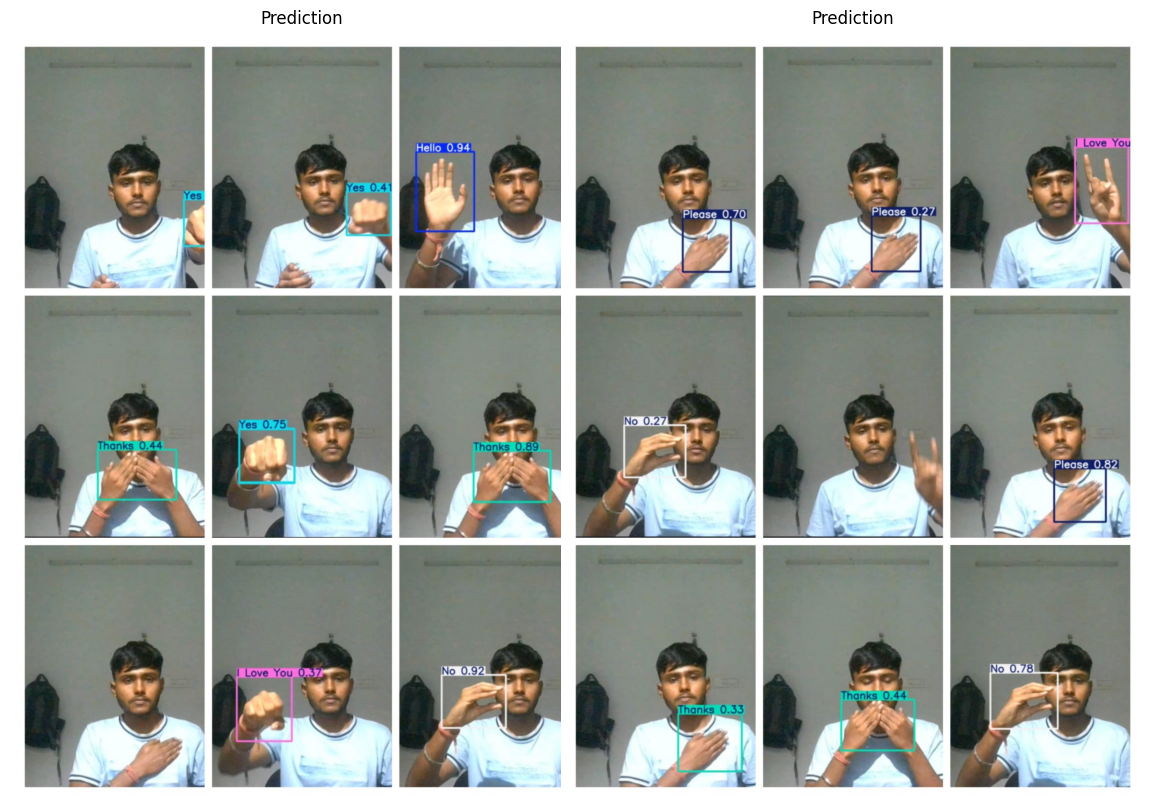

In [ ]:
print("Predictions On test Data")

img1 = cv2.imread('/content/drive/MyDrive/Action Sign Detection/prediction_1.jpg')
img2 = cv2.imread('/content/drive/MyDrive/Action Sign Detection/prediction2.jpg')

# Convert BGR to RGB for displaying correctly in matplotlib
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15, 10))

# Display image 1
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.title('Prediction')
plt.axis('off')

# Display image 2
plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.title('Prediction')
plt.axis('off')
plt.subplots_adjust(wspace=-0.1)
plt.show()